In [1]:
import os

#directory
directory = "data/train"

#labels
labels = os.listdir(directory)
labels

['Closed', 'no_yawn', 'Open', 'yawn']

In [2]:
import cv2

cv2_base_dir = os.path.dirname(os.path.abspath(cv2.__file__))
haar_eye = os.path.join(cv2_base_dir, 'data/haarcascade.xml')
haar_front = os.path.join(cv2_base_dir, 'data/haarcascade_frontalface_default.xml')




def open_closed_eye(IMG_SIZE, dir_path=directory):
    data = []
    categories = ['Closed', 'Open']
    
    for category in categories:
        path = os.path.join(dir_path, category)
        
        class_num = categories.index(category)
        class_num +=2
        print(class_num)
        
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            
            except Exception as e:
                print(e)
    
    return data




# Take the only face for labels 'yawn' and 'not_yawn'

def face_for_yawn(IMG_SIZE, direc=directory, face_cas_path=haar_front):
    data = []
    categories = ["yawn", "no_yawn"]
    
    for category in categories:
        path = os.path.join(direc, category)
        
        class_num = categories.index(category)
        print(class_num)
        
        for image in os.listdir(path):
            image_array = cv2.imread(os.path.join(path, image), cv2.IMREAD_COLOR)
            
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            
            for (x, y, w, h) in faces:
                try:
                    img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    roi_color = img[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    data.append([resized_array, class_num])
                    
                except Exception as e:
                    print(e)
    
    return data

In [3]:
import numpy as np

image_size = 256

def total_data():
    yawn_no_yawn = face_for_yawn(image_size)
    closed_open_eye = open_closed_eye(image_size)
    
    yawn_no_yawn.extend(closed_open_eye)
    
    return np.array(yawn_no_yawn)

data = total_data()

0
1
2
3


In [4]:
# separate label and features
X = []
y = []

for feature, label in data:
    X.append(feature)
    y.append(label)

In [5]:
# reshape the array

X = np.array(X)
X = X.reshape(-1, image_size, image_size, 3)

In [6]:
# LabelBinarizer
from sklearn.preprocessing import LabelBinarizer

label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

y = np.array(y)

In [7]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [8]:
# number of attributes in test
len(X_test)

578

In [9]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def plot_here():
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.plot(epochs, accuracy, "b", label="trainning accuracy")
    plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, "b", label="trainning loss")
    plt.plot(epochs, val_loss, "r", label="validation loss")
    plt.legend()
    plt.show()
    
def results(model_loc):
    model = load_model(model_loc)
    # Final evaluation of the model
    scores = model.evaluate(test_generator, verbose = 0)

    print('Test loss: %.4f%%' % scores[0])
    print('Test accuracy: %.4f%%' % scores[1])

    print("Large CNN Error: %.4f%%" % (100-scores[1]*100))

In [10]:
# Data Augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

BS = 16

train_generator = train_generator.flow(np.array(X_train), y_train, batch_size= BS)
test_generator = test_generator.flow(np.array(X_test), y_test, batch_size= BS)


## Model 1

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense


def model_1():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))

    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation="relu"))
    model.add(Dense(4, activation="softmax"))

    model.compile(loss = 'categorical_crossentropy',optimizer = 'adam' , metrics = ['accuracy'])
    
    return model

cnn_model = model_1()

print(cnn_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

def model_checkPoint(model_path):
    checkpoint = ModelCheckpoint(model_path, verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    return callbacks_list

In [13]:
from datetime import datetime

date = '{d:%m-%d__%H-%M}'.format( d=datetime.now() )

In [14]:
cnn_model_loc = f"data/models/cnn_{date}.h5"
callback_list = model_checkPoint(cnn_model_loc)

history = cnn_model.fit(train_generator, verbose=1, epochs=7, validation_data=test_generator,
                         validation_steps=len(test_generator), callbacks = callback_list)

Epoch 1/7
37/85 [============>.................] - ETA: 17s - loss: 0.4724 - acc: 0.8080
Epoch 00001: val_loss improved from inf to 0.47239, saving model to data/models/cnn_12-26__14-46.h5
85/85 [==============================] - 133s 2s/step - loss: 2.0995 - acc: 0.6474 - val_loss: 0.4724 - val_acc: 0.8080
Epoch 2/7
37/85 [============>.................] - ETA: 18s - loss: 0.3672 - acc: 0.8581
Epoch 00002: val_loss improved from 0.47239 to 0.36723, saving model to data/models/cnn_12-26__14-46.h5
85/85 [==============================] - 136s 2s/step - loss: 0.4733 - acc: 0.8189 - val_loss: 0.3672 - val_acc: 0.8581
Epoch 3/7
37/85 [============>.................] - ETA: 18s - loss: 0.2977 - acc: 0.8720
Epoch 00003: val_loss improved from 0.36723 to 0.29770, saving model to data/models/cnn_12-26__14-46.h5
85/85 [==============================] - 136s 2s/step - loss: 0.3314 - acc: 0.8768 - val_loss: 0.2977 - val_acc: 0.8720
Epoch 4/7
37/85 [============>.................] - ETA: 18s - los

In [15]:
results(cnn_model_loc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Test loss: 0.1692%
Test accuracy: 0.9377%
Large CNN Error: 6.2284%


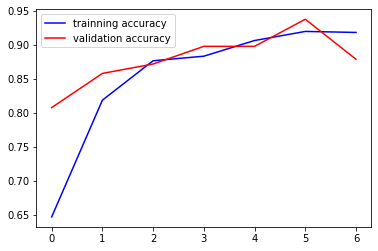

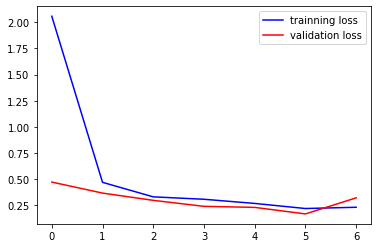

In [16]:
plot_here()

## Model 2

In [17]:
from tensorflow.keras.applications import ResNet50

def model_2():
    model = Sequential()

    model.add(ResNet50(input_shape= X_train.shape[1:], include_top=False, pooling='avg', weights='imagenet'))

    model.add(Dense(4, activation='softmax'))

    model.layers[0].trainable = False
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

res50_model = model_2()

print(res50_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [18]:
res50_model_loc = f"data/models/res50_{date}.h5"
callback_list = model_checkPoint(res50_model_loc)

history = res50_model.fit(train_generator, verbose=1, epochs=10, validation_data=test_generator,
                         validation_steps=len(test_generator), callbacks = callback_list)

Epoch 1/10
37/85 [============>.................] - ETA: 41s - loss: 0.2880 - acc: 0.8927
Epoch 00001: val_loss improved from inf to 0.28802, saving model to data/models/detection_res50_12-26__14-46.h5
85/85 [==============================] - 119s 1s/step - loss: 0.4210 - acc: 0.8426 - val_loss: 0.2880 - val_acc: 0.8927
Epoch 2/10
37/85 [============>.................] - ETA: 40s - loss: 0.2071 - acc: 0.9221
Epoch 00002: val_loss improved from 0.28802 to 0.20714, saving model to data/models/detection_res50_12-26__14-46.h5
85/85 [==============================] - 116s 1s/step - loss: 0.1516 - acc: 0.9510 - val_loss: 0.2071 - val_acc: 0.9221
Epoch 3/10
37/85 [============>.................] - ETA: 40s - loss: 0.1451 - acc: 0.9377
Epoch 00003: val_loss improved from 0.20714 to 0.14510, saving model to data/models/detection_res50_12-26__14-46.h5
85/85 [==============================] - 116s 1s/step - loss: 0.1407 - acc: 0.9547 - val_loss: 0.1451 - val_acc: 0.9377
Epoch 4/10
37/85 [========

In [19]:
results(res50_model_loc)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Test loss: 0.1448%
Test accuracy: 0.9377%
Large CNN Error: 6.2284%


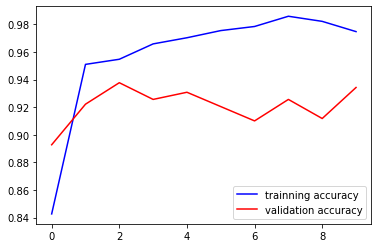

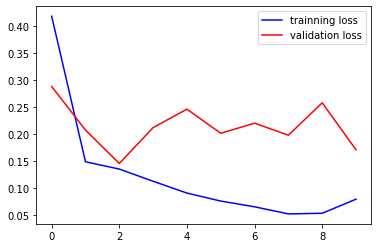

In [20]:
plot_here()